In [1]:
# =====================================================
# Phase 3 - Word2Vec Evaluation Notebook
# =====================================================

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
# ----------------------------
# 1. Load vocab + model
# ----------------------------
# Load vocab (rebuild the same way as training)
df = pd.read_csv("../data/clean_dataset.csv")

# For evaluation, rebuild a small vocab from sample
sample_df = df.sample(2000, random_state=42)
all_tokens = [list(code) for code in sample_df['code'].astype(str)] + \
             [list(doc) for doc in sample_df['docstring'].astype(str)]

flat_tokens = [tok for seq in all_tokens for tok in seq]
vocab = list(set(flat_tokens))
word_to_idx = {w: i for i, w in enumerate(vocab)}
idx_to_word = {i: w for w, i in word_to_idx.items()}

print("Vocab size:", len(vocab))

# Define Word2Vec (must match training!)
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.output = nn.Linear(embed_dim, vocab_size)
    def forward(self, x):
        emb = self.embeddings(x)
        return self.output(emb)

# Load trained model
EMBED_DIM = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Word2Vec(len(vocab), EMBED_DIM).to(device)
model.load_state_dict(torch.load("../word2vec/word2vec_model.pt", map_location=device))
model.eval()

print("Model loaded ✅")

Vocab size: 382
Model loaded ✅


In [3]:
import torch.nn.functional as F

def get_vector(word):
    idx = word_to_idx.get(word, None)
    if idx is None:
        return None
    tensor = torch.tensor([idx], dtype=torch.long).to(device)
    return model.embeddings(tensor).detach().cpu().numpy()[0]

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def most_similar(word, top_n=5):
    vec = get_vector(word)
    if vec is None:
        return []
    sims = {}
    for other in vocab:
        if other == word: continue
        o_vec = get_vector(other)
        if o_vec is not None:
            sims[other] = cosine_similarity(vec, o_vec)
    return sorted(sims.items(), key=lambda x: x[1], reverse=True)[:top_n]


In [4]:
test_words = ["d", "e", "f", "(", ")"]  # pick chars likely in vocab
for w in test_words:
    print(f"\nMost similar to '{w}':")
    for sim_word, score in most_similar(w, top_n=5):
        print(f"  {sim_word} -> {score:.3f}")



Most similar to 'd':


  5 -> 0.387
  ê -> 0.371
  行 -> 0.359
  H -> 0.323
  远 -> 0.314

Most similar to 'e':
  执 -> 0.350
  填 -> 0.348
  P -> 0.340
  响 -> 0.322
  ầ -> 0.319

Most similar to 'f':
  端 -> 0.392
  8 -> 0.387
  = -> 0.387
  đ -> 0.360
  转 -> 0.328

Most similar to '(':
  测 -> 0.454
  继 -> 0.364
  （ -> 0.328
  必 -> 0.318
  , -> 0.308

Most similar to ')':
  删 -> 0.487
  容 -> 0.355
  ; -> 0.352
  体 -> 0.347
  在 -> 0.332


c:\Users\Dell\OneDrive\Desktop\GenerativeAI_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31649 (\N{CJK UNIFIED IDEOGRAPH-7BA1}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Dell\OneDrive\Desktop\GenerativeAI_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36319 (\N{CJK UNIFIED IDEOGRAPH-8DDF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Dell\OneDrive\Desktop\GenerativeAI_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Dell\OneDrive\Desktop\GenerativeAI_Project\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 31449 (\N{CJK UNIFIED IDEOGRAPH-7AD9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Dell\OneDrive\Desktop\Gener

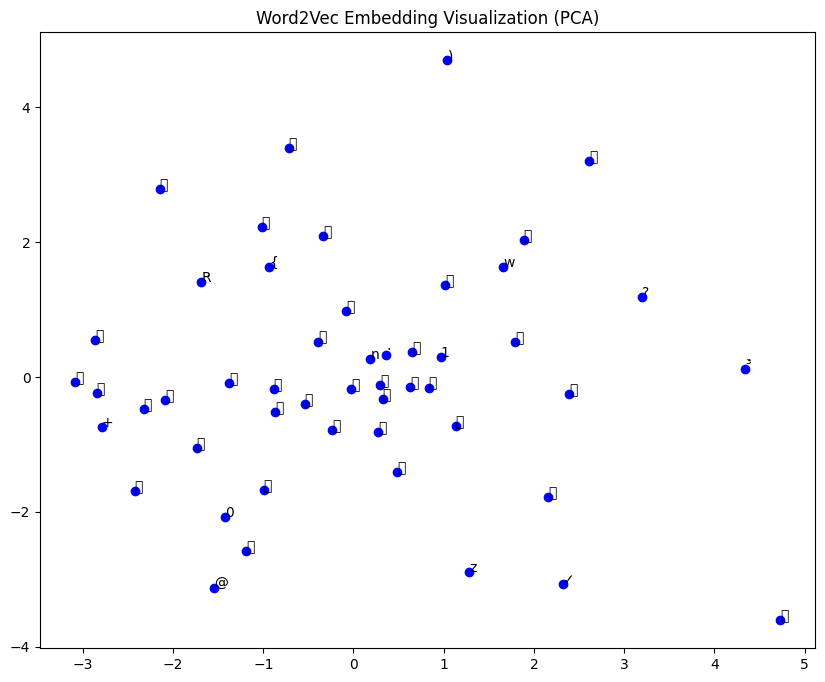

In [5]:
# Get vectors for a random sample of vocab
sample_words = np.random.choice(vocab, size=50, replace=False)
vectors = np.array([get_vector(w) for w in sample_words])

# Reduce dimensions
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# Plot
plt.figure(figsize=(10,8))
plt.scatter(reduced[:,0], reduced[:,1], c="blue")

for i, word in enumerate(sample_words):
    plt.annotate(word, (reduced[i,0], reduced[i,1]))

plt.title("Word2Vec Embedding Visualization (PCA)")
plt.show()
